In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Single plant

In [6]:
data_path = '/Users/lukecullen/PycharmProjects/petrochemical-data/data/combined/'

output_path = '/Users/lukecullen/Library/CloudStorage/OneDrive-UniversityofCambridge/PhD/C-THRU/paper_2_finalisation/figures/'

colors = ['#d73027', '#91bfdb', '#4575b4', '#fc8d59']  #['#E66070', '#E6A730', '#6EE588', '#498DE6', '#A055E6']

def filter_df(df, cols, filters):
    for col, filt in zip(cols, filters):
        df = df[[i in filt for i in df[col]]]
    return df

In [7]:
types_used = ['Direct Process', 'Direct Utilities', 'Indirect Utilities', 'Raw Material']
cols = ['2020', '2020_sigma','Type']

def summarise_sigma_ratios(df):
    summ = filter_df(df, ['Gas', 'Type'], [['CO2e_100a'], types_used])[cols].groupby('Type').sum()
    summ['ratio'] = summ['2020_sigma']/np.sum(summ['2020_sigma'])
    summ['perc'] = (np.sum(summ['2020_sigma'])/np.sum(summ['2020']))*summ['ratio']*100
    return summ

unspecified = pd.read_parquet(data_path+'icisFacilityEmissions_allIhsProcesses_unspecified.parquet')
unspecified_summ = summarise_sigma_ratios(unspecified)

mean = pd.read_parquet(data_path+'icisFacilityEmissions_ihsMean_w_uncertainties_allgases_dedoubled.parquet')
mean_summ = summarise_sigma_ratios(mean)

weighted = pd.read_parquet(data_path+'icisFacilityEmissions_ihsWeighted_w_uncertainties_allgases_dedoubled.parquet')
weighted_summ = summarise_sigma_ratios(weighted)
# del weighted

specific = pd.read_parquet(data_path+'icisFacilityEmissions_allIhsProcesses_w_uncertainties_dedoubled1.parquet')
specific_summ = summarise_sigma_ratios(specific)

In [8]:
specific_summ.sum()

2020          2.794600e+07
2020_sigma    4.433471e+05
ratio         1.000000e+00
perc          1.586442e+00
dtype: float64

In [9]:
weighted_summ.sum()

2020          3.550963e+06
2020_sigma    5.202855e+05
ratio         1.000000e+00
perc          1.465195e+01
dtype: float64

In [10]:
world_total = 1885
world_error = 638
total_error = (weighted_summ['2020_sigma'].sum()/weighted_summ['2020'].sum())*world_total

In [11]:
def corect_for_uct(summ):
    summ['2020_sigma'] = summ['2020_sigma']*(world_error/total_error)
    summ['ratio'] = summ['2020_sigma']/np.sum(summ['2020_sigma'])
    summ['perc'] = (np.sum(summ['2020_sigma'])/np.sum(summ['2020']))*summ['ratio']*100
    return summ

unspecified_summ, mean_summ, weighted_summ, specific_summ = corect_for_uct(unspecified_summ), corect_for_uct(mean_summ), corect_for_uct(weighted_summ), corect_for_uct(specific_summ)

In [12]:
## Create bars
bars = pd.DataFrame([unspecified_summ['perc'], mean_summ['perc'], weighted_summ['perc'], specific_summ['perc']], index=['Product\nonly', 'Facility\ndata', 'Feedstock\ndata', 'Specific\nprocess'])

In [13]:
## Get places that are producing in 2020
weighted_cut = filter_df(weighted, ['Gas', 'Type'], [['CO2e_100a'], types_used])
grouped_df = weighted_cut.groupby(list(weighted_cut.columns[:14]))
filtered_weighted = grouped_df.filter(lambda x: (x['2020'] > 0).any())[cols]

In [47]:
tot_uct = filtered_weighted['2020_sigma'].sum()

def get_percentages(df, filt_type):
    sorted_df = filter_df(df, ['Type'], [[filt_type]]).sort_values(['2020_sigma'], ascending=False).reset_index(drop=True)
    portion_left = np.sum(filter_df(df, ['Type'], [[i for i in types_used if i!=filt_type]])['2020_sigma'])/tot_uct
    sorted_df['CumSum'] = sorted_df['2020_sigma'].cumsum()
    sorted_df['Percentage_through'] = sorted_df.index/len(sorted_df)
    sorted_df['Percentage'] = sorted_df['CumSum'] / sorted_df['2020_sigma'].sum()
    sorted_df['Perc_total'] = portion_left+((1-sorted_df['Percentage'])*(1-portion_left))
    return sorted_df

dps = get_percentages(filtered_weighted, 'Direct Process')
dus = get_percentages(filtered_weighted, 'Direct Utilities')
ius = get_percentages(filtered_weighted, 'Indirect Utilities')
rms = get_percentages(filtered_weighted, 'Raw Material')

In [48]:
# # Plant calcs
# plant_deets = specific.iloc[24392]
# types_used = ['Direct Process', 'Direct Utilities', 'Indirect Utilities', 'Raw Material']
# all_plant = filter_df(specific, list(plant_deets.index[:13])+['Gas', 'Type'], [[i] for i in list(plant_deets.values[:13])]+[['CO2e_100a'], types_used])
#
# mean_plant = filter_df(mean, list(plant_deets.index[:6])+['Type', 'Gas'], [[str(i)] for i in list(plant_deets.values[:6])]+[types_used, ['CO2e_100a']])
#
# weighted_plant = filter_df(weighted, list(plant_deets.index[:6])+['Type', 'Gas'], [[str(i)] for i in list(plant_deets.values[:6])]+[types_used, ['CO2e_100a']])

In [49]:
# # Plant specific graphs
#
# def get_uct(initial, name, specific=False):
#     pivoted = filter_df(initial, ['Type'], [types_used])[['Type', '2020', '2020_sigma']].set_index('Type').T
#     if specific: df = pd.DataFrame((pivoted.loc['2020']*0.1)/pivoted.loc['2020'].sum()).T
#     else: df = pd.DataFrame(pivoted.loc['2020_sigma']/pivoted.loc['2020'].sum()).T
#     df.index = [name]
#     return df
#
# mean_uct = get_uct(mean_plant, 'Mean')
# weighted_uct = get_uct(weighted_plant, 'Weighted')
# choice_process = filter_df(all_plant, ['PROCESS'], [[plant_deets['PROCESS']]])
# ind_uct = get_uct(choice_process, 'Specific', specific=True)
# bars = pd.concat((mean_uct, weighted_uct, ind_uct)).rename(columns={'Raw Material':'Feedstock'})*100
# bars.loc['Weighted'] = [min(i,j) for (i,j) in zip(bars.loc['Mean'], bars.loc['Weighted'])]
#
# improvement = pd.DataFrame([pd.DataFrame(bars.loc['Specific']).sum()]*3).rename(columns={'Specific':0})
# #quant = bars.loc['Specific']
# improvement.index = ['Direct Utilities', 'Indirect Utilities', 'Feedstock']
# for i in range(1,101):
#     improvement[i] = improvement[0]-(i/100)*bars.loc['Specific']
#
# improvement = improvement*(100/((bars.loc['Specific']).sum()))

In [50]:
# Overall calcs
# all_filt = filter_df(all_posses, ['Gas', 'Type'], [['CO2e_100a'], types_used])
# all_filt = all_filt.groupby(list(all_filt.columns[:13])+['Type', 'Gas']).mean().reset_index()
#
# mean_filt = filter_df(mean, ['Gas', 'Type'], [['CO2e_100a'], types_used])
#
# weighted_filt = filter_df(weighted, ['Gas', 'Type'], [['CO2e_100a'], types_used])

In [53]:
specific_filt = filter_df(specific, ['Gas', 'Type'], [['CO2e_100a'], types_used])
sp = specific_filt[[i not in ['AMMONIA','UREA'] for i in specific_filt['PRODUCT']]]
sp = sp[[i not in ['~OTHER PRODUCERS','~VARIOUS','~RECYCLERS'] for i in sp['PRODUCT']]]
spec_sorted = sp.drop(columns=['PROCESS']).groupby(list(sp.columns[:13])+['Gas','Type']).mean().reset_index().groupby(list(sp.columns[:13])+['Gas']).sum().reset_index().sort_values('2020_sigma', ascending=False)
# spec_sorted = sp.groupby(list(sp.columns[:13])+['Gas','Type']).mean().reset_index().groupby(list(sp.columns[:13])+['Gas']).sum().reset_index().sort_values('2020_sigma', ascending=False)
spec_sorted[spec_sorted.columns[:11]] = spec_sorted[spec_sorted.columns[:11]].astype(str)

In [54]:
weighted_filt = filter_df(weighted, ['Gas', 'Type'], [['CO2e_100a'], types_used])
wp = weighted_filt[[i not in ['AMMONIA','UREA'] for i in weighted_filt['PRODUCT']]]
wp = wp[[i not in ['~OTHER PRODUCERS','~VARIOUS','~RECYCLERS'] for i in wp['PRODUCT']]]
weighted_sorted = wp.groupby(list(weighted_filt.columns[:13])+['Gas']).sum().reset_index().sort_values('2020_sigma', ascending=False)
weighted_sorted[weighted_sorted.columns[:11]] = weighted_sorted[weighted_sorted.columns[:11]].astype(str)
merged = weighted_sorted.merge(spec_sorted, on=list(weighted_sorted.columns[:11])+['Gas'], how='left')

In [55]:
sp_vals = merged[['2020_sigma_x', '2020_sigma_y']]
sp_vals['reduction'] = merged['2020_sigma_x']-merged['2020_sigma_y']
sp_vals = sp_vals.sort_values('reduction', ascending=0)
sp_vals = sp_vals[sp_vals['2020_sigma_x'] > 0].reset_index(drop=True)
sp_vals['CumSum'] = sp_vals['reduction'].cumsum()
sp_vals['Percentage_through'] = sp_vals.index/len(sp_vals)
sp_vals['Percentage'] = sp_vals['CumSum'] / sp_vals['2020_sigma_x'].sum()
sp_vals['Perc_total'] = 1-sp_vals['Percentage']

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_15402/3993266482.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_vals['reduction'] = merged['2020_sigma_x']-merged['2020_sigma_y']


In [56]:
# # Get reduction for specifying processes by order of uncertainty
# priority_facils = mean_filt[[i not in ['AMMONIA','UREA'] for i in mean_filt['PRODUCT']]].groupby(list(all_filt.columns[:13])+['Gas']).sum().reset_index().sort_values('2020_sigma', ascending=False)
# all_types = all_filt.groupby(list(all_filt.columns[:13])+['Gas']).sum().reset_index()
# all_types[list(all_filt.columns[:13])+['Gas']] = all_types[list(all_filt.columns[:13])+['Gas']].astype(str)
# ranked = priority_facils.merge(all_types, on=list(all_filt.columns[:13])+['Gas'], how='left')
#
# ps = []
# for i in range(0,101):
#     uct = ranked[:int((i/100)*len(ranked))]['2020_sigma_y'].sum()+ranked[int((i/100)*len(ranked)):]['2020_sigma_x'].sum()
#     value = ranked[:int((i/100)*len(ranked))]['2020_y'].sum() + ranked[int((i/100)*len(ranked)):]['2020_x'].sum()
#     ps = ps + [uct/value]
# ps = (100/ps[0])*np.array(ps)

In [28]:
# # Get reduction for specifying processes by order of uncertainty
# priority_facils = mean_filt.groupby(list(weighted_filt.columns[:13])+['Gas']).sum().reset_index().sort_values('2020_sigma', ascending=False)
# priority_facils = pd.concat((priority_facils[priority_facils['PRODUCT']=='ETHYLENE'], priority_facils[priority_facils['PRODUCT']!='ETHYLENE']))
# weighted_types = weighted_filt.groupby(list(weighted_filt.columns[:13])+['Gas']).sum().reset_index()
# # all_types[list(all_filt.columns[:13])+['Gas']] = all_types[list(all_filt.columns[:13])+['Gas']].astype(str)
# ranked = priority_facils.merge(weighted_types, on=list(weighted_filt.columns[:13])+['Gas'], how='left')
#
# ew = []
# for i in range(0,101):
#     uct = ranked[:int((i/100)*len(ranked))]['2020_sigma_y'].sum()+ranked[int((i/100)*len(ranked)):]['2020_sigma_x'].sum()
#     value = ranked[:int((i/100)*len(ranked))]['2020_y'].sum() + ranked[int((i/100)*len(ranked)):]['2020_x'].sum()
#     ew = ew + [uct/value]
# ew = (100/ew[0])*np.array(ew)

In [29]:
# tot_value = np.sum(mean_filt['2020_sigma'])/np.sum(mean_filt['2020'])
# overall = pd.DataFrame([tot_value]*6)*100
# overall.index = ['Ethylene Feedstock\nWeighting', 'Process Specification', 'Direct Process', 'Direct Utilities', 'Indirect Utilities', 'Feedstock']
#
# w_value = tot_value-(np.sum(weighted_filt['2020_sigma'])/np.sum(weighted_filt['2020']))
# w_target = 1-(len(weighted_filt[weighted_filt['PRODUCT']=='ETHYLENE'])/len(weighted_filt))/w_value
# specific_target = np.sum(all_filt['2020_sigma'])/np.sum(all_filt['2020'])
# type_targets = tot_value-(weighted_filt.groupby('Type').sum()['2020_sigma'].values/np.sum(weighted_filt['2020']))
#
# target_vals = np.array([w_target, specific_target]+list(type_targets))
#
# for i in range(1,101):
#     temp = (overall[0]-i*(tot_value-target_vals))*(1/tot_value)
#     temp[0] = ew[i]
#     temp[1] = ps[i]
#     overall[i] = temp
#
# overall[0] = overall[0]*(1/tot_value)

In [57]:
world_total = 1885
world_error = 638
total_error = (weighted_summ['2020_sigma'].sum()/weighted_summ['2020'].sum())*world_total

In [31]:
weighted_summ

,2020,2020_sigma,ratio,perc
Type,,,,
Direct Process,2.414922e+05,54116.548720,0.045027,1.523996
Direct Utilities,1.340245e+05,130120.642966,0.108266,3.664376
Indirect Utilities,6.877074e+05,483557.362990,0.402339,13.617640
Raw Material,2.487739e+06,534069.899403,0.444368,15.040142


In [32]:
unspecified_summ

,2020,2020_sigma,ratio,perc
Type,,,,
Direct Process,205887.606542,18823.741582,0.023034,1.332172
Direct Utilities,86560.102398,106611.272671,0.130454,7.544970
Indirect Utilities,348795.995614,371459.088138,0.454533,26.288474
Raw Material,771767.534766,320338.413365,0.391980,22.670620


In [77]:
# Target values
target_values = np.arange(0, 0.26, 0.025)

# Initialize an empty DataFrame to store the nearest rows
nearest_rows_rm = pd.DataFrame(columns=rms.columns)
nearest_rows_ius = pd.DataFrame(columns=ius.columns)
nearest_rows_sp = pd.DataFrame(columns=sp_vals.columns)

# Loop through the target values
for target_value in target_values:
    # Calculate the absolute difference between the column values and the target value
    rms['Diff'] = abs(rms['Percentage_through'] - target_value)
    ius['Diff'] = abs(ius['Percentage_through'] - target_value)
    sp_vals['Diff'] = abs(sp_vals['Percentage_through'] - target_value)

    # Find the row with the column value nearest to the target value
    nearest_row_rm = rms.loc[rms['Diff'].idxmin()]
    nearest_row_ius = ius.loc[ius['Diff'].idxmin()]
    nearest_row_sp = sp_vals.loc[sp_vals['Diff'].idxmin()]

    # Append the nearest row to the nearest_rows DataFrame
    nearest_rows_rm = pd.concat((nearest_rows_rm, pd.DataFrame(nearest_row_rm).transpose()), ignore_index=True) #.append(nearest_row_rm, ignore_index=True)
    nearest_rows_ius = pd.concat((nearest_rows_ius, pd.DataFrame(nearest_row_ius).transpose()), ignore_index=True) #.append(nearest_row_ius, ignore_index=True)
    nearest_rows_sp = pd.concat((nearest_rows_sp, pd.DataFrame(nearest_row_sp).transpose()), ignore_index=True) #.append(nearest_row_sp, ignore_index=True)

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_15402/3418390737.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  nearest_rows_sp = pd.concat((nearest_rows_sp, pd.DataFrame(nearest_row_sp).transpose()), ignore_index=True) #.append(nearest_row_sp, ignore_index=True)


In [92]:
grid_values = np.outer(nearest_rows_rm['Perc_total'], nearest_rows_sp['Perc_total']).astype(float)
grid_values2 = np.outer(nearest_rows_rm['Perc_total'], nearest_rows_ius['Perc_total']).astype(float)

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_15402/457507028.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r')


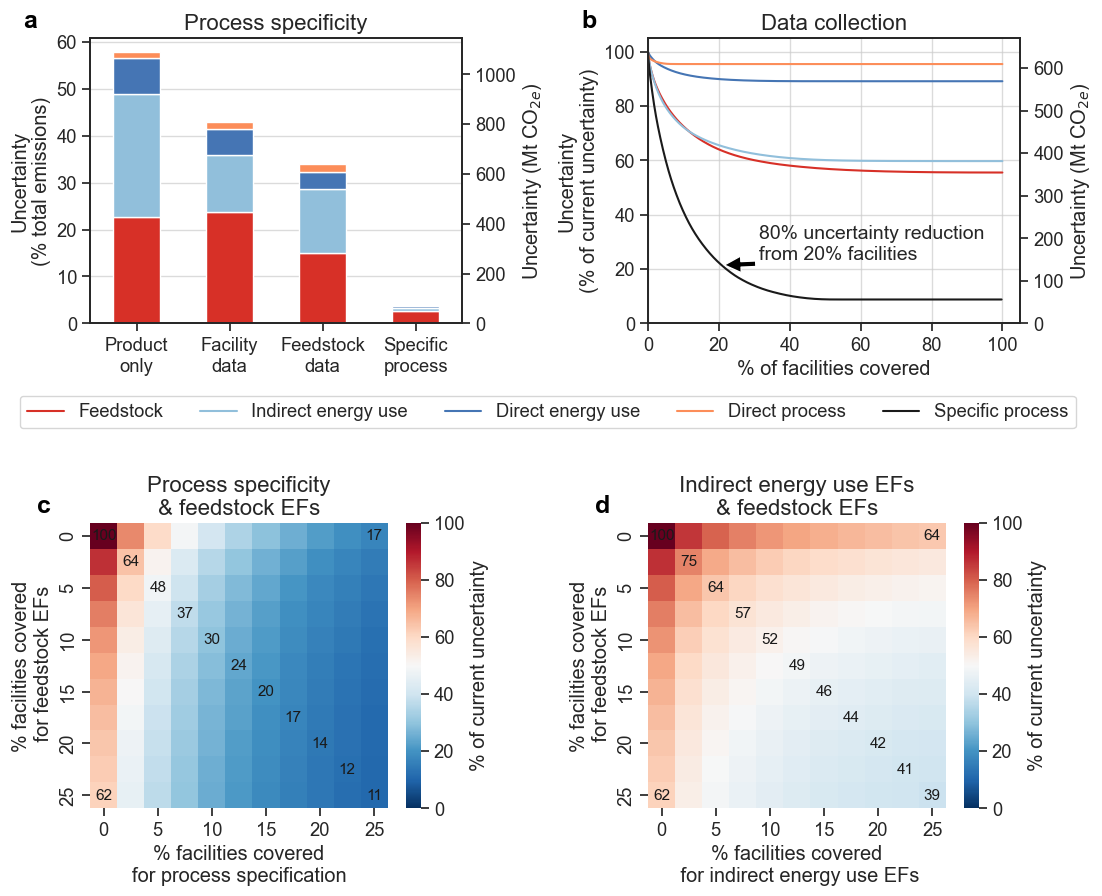

In [135]:
from matplotlib.colors import TwoSlopeNorm

fig = plt.figure(figsize=[12,10], facecolor='white')
t_font = 16

colors_used = colors + ['k']
cmap = plt.cm.get_cmap('RdBu_r')

norm = TwoSlopeNorm(vmin=0, vcenter=50, vmax=100)
plt.rcParams['font.size'] = 14
sns.set(font_scale=1.2)
sns.set_style('ticks')

axs = [fig.add_subplot(2,2,1), fig.add_subplot(2,2,2), fig.add_subplot(2,2,3), fig.add_subplot(2,2,4)]
bars = bars[['Raw Material', 'Indirect Utilities', 'Direct Utilities', 'Direct Process']]
bars.plot.bar(ax=axs[0], stacked=True, color=colors_used, legend=False)
axs[0].set_xticks([0,1,2,3], bars.index, rotation=0)
axs[0].set_title('Process specificity', fontsize=t_font)
axs[0].set_xlabel(None)
axs[0].set_ylabel('Uncertainty\n(% total emissions)')
axs[0].grid(axis='y', alpha=0.7)
ax2 = axs[0].twinx()
((bars/100)*world_total).plot.bar(ax=ax2, stacked=True, color=colors_used, legend=False, alpha=0)
ax2.set_ylabel('Uncertainty (Mt CO$_{2e}$)')


for df, color, label in zip([rms, ius, dus, dps, sp_vals], colors_used, ['Feedstock', 'Indirect energy use', 'Direct energy use', 'Direct process', 'Specific process']):#improvement.T.plot(ax=axs[1], color=colors_used)
    axs[1].plot(df['Percentage_through']*100, df['Perc_total']*100, color=color, label=label)

axs[1].set_title('Data collection', fontsize=t_font)
axs[1].set_xlabel('% of facilities covered')
axs[1].set_ylabel('Uncertainty\n(% of current uncertainty)')
axs[1].grid(axis='both', alpha=0.7)
axs[1].set_ylim([0,105])
axs[1].set_xlim([0,105])
ax2 = axs[1].twinx()
ax2.plot(df['Percentage_through']*100, (df['Perc_total']*100)*world_error/100, color=color, alpha=0)
ax2.set_ylim([0, world_error*1.05])
ax2.set_ylabel('Uncertainty (Mt CO$_{2e}$)')
axs[1].legend(loc='lower center', bbox_to_anchor=(-0.27, -0.4), ncol=5)

grid_values[0,0] = 1
heatmap = sns.heatmap(grid_values*100, fmt=".0f", cmap=cmap, ax=axs[2], cbar=True, cbar_kws={'label':'% of current uncertainty'}, annot_kws={'fontsize': 11}, norm=norm)
axs[2].set_xticks(np.arange(0.5, 11, 2))
axs[2].set_xticklabels(np.arange(0, 26, 5))
axs[2].set_yticks(np.arange(0.5, 11, 2))
axs[2].set_yticklabels(np.arange(0, 26, 5))
axs[2].set_title('Process specificity\n& feedstock EFs', fontsize=t_font)
axs[2].set_xlabel('% facilities covered\nfor process specification')
axs[2].set_ylabel('% facilities covered\n for feedstock EFs')

# Set the corner annotations
for i in range(len(grid_values)):
    for j in range(len(grid_values)):
        if i == j or (i==0 and j==len(grid_values)-1) or (j==0 and i==len(grid_values)-1):  # Check if it is a corner square
            axs[2].annotate(f'{grid_values[i, j]*100:.0f}',
                        xy=(j + 0.5, i + 0.5),
                        ha='center', va='center',
                        fontsize=11, color='k')

grid_values2[0,0] = 1
heatmap2 = sns.heatmap(grid_values2*100, fmt=".0f", cmap=cmap, ax=axs[3], cbar=True, cbar_kws={'label':'% of current uncertainty'}, annot_kws={'fontsize': 11}, norm=norm)
axs[3].set_xticks(np.arange(0.5, 11, 2))
axs[3].set_xticklabels(np.arange(0, 26, 5))
axs[3].set_yticks(np.arange(0.5, 11, 2))
axs[3].set_yticklabels(np.arange(0, 26, 5))
axs[3].set_title('Indirect energy use EFs\n& feedstock EFs', fontsize=t_font)
axs[3].set_xlabel('% facilities covered\n for indirect energy use EFs')
axs[3].set_ylabel('% facilities covered\n for feedstock EFs')

# Set the corner annotations
for i in range(len(grid_values2)):
    for j in range(len(grid_values2)):
        if i == j or (i==0 and j==len(grid_values2)-1) or (j==0 and i==len(grid_values2)-1):  # Check if it is a corner square
            axs[3].annotate(f'{grid_values2[i, j]*100:.0f}',
                        xy=(j + 0.5, i + 0.5),
                        ha='center', va='center',
                        fontsize=11, color='k')

w=-0.18
h=1.1
fontsize = 18
axs[0].text(w, h, 'a', transform = axs[0].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[1].text(w, h, 'b', transform = axs[1].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[2].text(w, h, 'c', transform = axs[2].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[3].text(w, h, 'd', transform = axs[3].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

# Insert text box with comment in middle of axs[1] and an arrow from the left side of the text box to point [21, 21]
axs[1].annotate('80% uncertainty reduction\nfrom 20% facilities', xy=(21.5, 21.5), xytext=(25, 15), fontsize=fontsize-4, textcoords='offset points', arrowprops=dict(facecolor='black'), ha='left', va='center')

plt.subplots_adjust(hspace=0.7, wspace=0.5)
#legend = plt.figlegend(axs[1].get_legend_handles_labels(), loc='lower center', ncol=5)

# Adjust the spacing between subplots
#fig.tight_layout()

In [136]:
fig.savefig(output_path+'Figure_6.png', bbox_inches='tight',dpi=300)
fig.savefig(output_path+'Figure_6.eps', format='eps', bbox_inches='tight',dpi=300)

#fig.savefig('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/uncertainty_reduction_update.png', bbox_inches='tight', dpi=150)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
